# Import libraries

We first import the necessary libraries needed for this project.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Question 1

In [2]:
# Using a simple Fourier pricing technique (using 𝑁 = 100 intervals, and using an effective upper bound of integration of 30), 
# price a vanilla call option assuming that the underlying share follows the Heston model dynamics.

T = 1                   #expiry time of option
S_0 = 100               #starting share value
K = 100                 #strike price
V_0 = 100               #starting firm value
r = 0.08                #interest rate
sigma = 0.30            #share volatility
debt = 175              #firm debt
correlation = 0.2       #correlation between share and firm
recovery_rate = 0.25    #firm recovery rate
frequency = 12          #Monthly simulations for a year

v0 = 0.06               #
kappa = 9               #
theta = 0.06            #
rho = -0.4              #

In [3]:
# define the functions that will be used to calculate the price of the European vanilla call option

a = sigma**2/2

def b(u):
  return kappa - rho*sigma*1j*u

def c(u):
  return -(u**2+1j*u)/2

def d(u):
  return np.sqrt(b(u)**2-4*a*c(u))

def xminus(u):
  return (b(u)-d(u))/(2*a)

def xplus(u):
  return (b(u)+d(u))/(2*a)

def g(u):
  return xminus(u)/xplus(u)

def C(u):
  vall = T*xminus(u)-np.log((1-g(u)*np.exp(-T*d(u)))/(1-g(u)))/a
  return r*T*1j*u + theta*kappa*vall

def D(u):
  val1 = 1-np.exp(-T*d(u))
  val2 = 1-g(u)*np.exp(-T*d(u))
  return (val1/val2)*xminus(u)

def log_char(u):
  return np.exp(C(u) + D(u)*v0 + 1j*u*np.log(S_0))

def adj_char(u):
  return log_char(u-1j)/log_char(-1j)

In [4]:
N = 100               #Number of intervals
t_max = 30            #Upper bound of discretized interval t
k_log = np.log(K)     #Log of strike price K

delta_t = t_max/N
from_1_to_N = np.linspace(1, N, N)
t_n = (from_1_to_N-1/2) * delta_t

In [5]:
# Approximate integral estimates
first_integral = sum((((np.exp(-1j*t_n*k_log)*adj_char(t_n)).imag)/t_n)*delta_t)
second_integral = sum((((np.exp(-1j*t_n*k_log)*log_char(t_n)).imag)/t_n)*delta_t)

fourier_call_val = S_0 * (1/2 + first_integral/np.pi) - np.exp(-r*T)*K*(1/2 + second_integral/np.pi)

In [6]:
print("Using the Heston model assumption, the price of the plain vanilla European call option \
using the Simple Fourier Transformation is {}".format(fourier_call_val))

Using the Heston model assumption, the price of the plain vanilla European call option using the Simple Fourier Transformation is 13.734895692109077


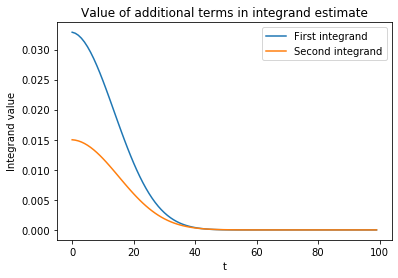

In [7]:
# Plot the first and second integrand against the bound of discretized interval (t)

plt.title("Value of additional terms in integrand estimate")
plt.plot((((np.exp(-1j*t_n*k_log)*adj_char(t_n)).imag)/t_n)*delta_t,
label="First integrand")
plt.plot((((np.exp(-1j*t_n*k_log)*log_char(t_n)).imag)/t_n)*delta_t,
label="Second integrand")
plt.xlabel("t")
plt.ylabel("Integrand value")
plt.legend()
plt.show()

In [8]:
# To double check the work, we also compare the call price under the Black-Scholes assumption.
# While this isn't required, it is a good way to check the validity of our answer to question 1.

d_1_stock = (np.log(S_0/K) + (r + sigma**2/2) * T)/(sigma*np.sqrt(T))
d_2_stock = d_1_stock - sigma*np.sqrt(T)

analytic_call_price = S_0*norm.cdf(d_1_stock) - K*np.exp(-r*T)*norm.cdf(d_2_stock)

print("Using the Black-Scholes model assumption, the price of the plain vanilla European call option \
using the analytical method is {}".format(analytic_call_price))

Using the Black-Scholes model assumption, the price of the plain vanilla European call option using the analytical method is 15.711312547892973


# Question 2

According to the CEV model, the share price evolves according to the following recursive formula

$S_{t_{i+1}} = S_{t_i} e^{r-\frac{\sigma^2 (t_i,t_{i+1})}{2}(t_{i+1}-t_i)+\sigma(t_i, t_{i+1})\sqrt{t_{i+1}-t_i}Z}$

and the volatility follows the following deterministic formula

$\sigma(t_i,t_{i+1}) = \sigma(S_{ti})^{\gamma-1}$

We can now define the functions to represent the 2 formulas.

In [9]:
def sigma_cev(sigma, S_t, gamma):
    return sigma * S_t ** (gamma - 1)

def getSharePath(S_0, t, dt, r, sigma, gamma, Z_list):
    if abs(t) <= dt: #as subtraction is not exact
        return [S_0]
    Z = Z_list.pop()
    path = getSharePath(S_0, t - dt, dt, r, sigma, gamma, Z_list)
    S_t_minus_1 = path[-1]
    sigma_t = sigma_cev(sigma, S_t_minus_1, gamma)
    exponent = (r - (sigma_t**2)/2)*dt + sigma_t * np.sqrt(dt) * Z
    S_t = S_t_minus_1 * np.exp(exponent)
    path.append(S_t)
    return path

Basically, a recursive function can be used to represent the recursive formula, with each recursive call looking to get the value of the share price in the previous time node.(i.e. previous month) The base case would be when t=0, for which we would return the initial share price S_0 of 100. 

Since we wish to keep track of the value at each node, we store the result at each stage in an list and return it to the caller for which each caller subsequently adds the value it has calculated to the list. Since the first value returned at the base case is the initial value, each caller will append to the end of the list.

At each stage, we also generate a new standard normal random variable Z to be passed in to the recursive call. Ultimately, this getSharePath function will return a list of size 12 containing the values of the share for each month.

After defining the functions, we can now define the parameters needed. For this exercise, we assume an initial share price of 100 and a risk free rate of 10%.

In [10]:
sigma = 0.3
S_0 = 100
gamma = 0.75
r = 0.08
dt = 1/12
T = 1

We then start simulating the paths for each sample size from 1000 to 50000.

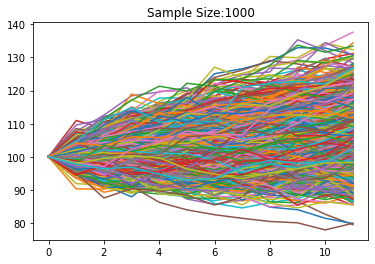

In [11]:
# List for storing terminal stock prices for different sample sizes, will be used in part 3
terminalStockPrices = []

for sampleSize in range(1000, 51000, 1000):
    z_matrix = norm.rvs(size = [sampleSize, 12])
    #print("Sample Size: " + str(sampleSize))
    # List, S_T, for storing terminal stock prices, will be used in part 3
    S_T = []
    share_path_list = []
    for index in range(0, sampleSize):
        z_vector = list(z_matrix[index])
        share_path = getSharePath(S_0, T, dt, r, sigma, gamma, z_vector)
        #print("Share Path " + str(share_path))
        share_path_list.append(share_path)
        S_T.append(share_path[-1])
        #plt.plot(share_path)
    terminalStockPrices.append(S_T)
    #share_path_list now contains the list of all paths for the given sample size.
    if sampleSize == 1000:
        plt.figure()
        plt.title("Sample Size:" + str(sampleSize))
        for share_path in share_path_list:
            plt.plot(share_path)
        plt.show()


Due to computational limitations, we only plot the share paths for sample size of 1000.

# Question 3
Calculate Monte Carlo estimates, as well as the standard deviations for these estimates, for the price of a vanilla call option (with the same strike term as in Submission 1).

In [12]:
def discountedCallPayoff(S_T, strike, r, T):
    """Evaluate the discounted payoff of a vanilla CALL"""
    return np.exp(-r * T) * np.maximum(S_T - strike, 0)

# Empty lists which can be used to store estimates for different sample sizes
callEstimates = [None] * 50
callStd = [None] * 50

sampleSizes = 1000 * np.array(range(1, 51))

# Generate Monte Carlo estimates as a function of sample size
for i, sampleSize in enumerate(sampleSizes):
    S_T = np.array(terminalStockPrices[i])
    callValue = discountedCallPayoff(S_T, K, r, T)
    callEstimates[i] = np.mean(callValue)
    callStd[i] = np.std(callValue) / np.sqrt(sampleSize)

# Question 4
Plot the Monte Carlo estimates generated in part 3 with respect to sample size, as well as three standard deviation error bounds around these estimates.

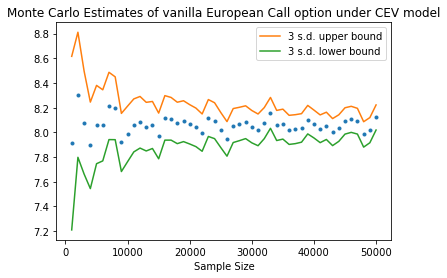

In [15]:
plt.title("Monte Carlo Estimates of vanilla European Call option under CEV model")
plt.xlabel("Sample Size")
# preliminary check indicates fourier_call_val is far from MC est. under CEV model, probably not plotting it
# plt.plot(sampleSizes, [fourier_call_val] * 50, label="Fourier est. under Heston model")
plt.plot(sampleSizes, callEstimates, ".")
plt.plot(sampleSizes, callEstimates + 3 * np.array(callStd), label="3 s.d. upper bound")
plt.plot(sampleSizes, callEstimates - 3 * np.array(callStd), label="3 s.d. lower bound")
plt.legend()
plt.show()